<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segmentation-ResNet18-in-FastAI" data-toc-modified-id="Segmentation-ResNet18-in-FastAI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Segmentation ResNet18 in FastAI</a></span><ul class="toc-item"><li><span><a href="#Half-size:-128x800" data-toc-modified-id="Half-size:-128x800-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Half-size: 128x800</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></li><li><span><a href="#Original-size:-256x1600" data-toc-modified-id="Original-size:-256x1600-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Original-size: 256x1600</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Predictions</a></span></li><li><span><a href="#Outputs" data-toc-modified-id="Outputs-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Outputs</a></span></li></ul></li></ul></div>

# Segmentation ResNet18 in FastAI

> Training notebook for this architecture.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.preprocessing import *
from steel_segmentation.models.dls import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [ ]:
fastai.__version__

'2.2.3'

In [ ]:
torch.__version__

'1.7.0'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Jan 26 15:44:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   33C    P0    43W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print_competition_data(models_dir)

models/ResNet34-Unet-256-stage1.pth
models/ResNet18_kaggle_class.pth
models/ResNet18-Unet-256-stage3.pth
models/.ipynb_checkpoints
models/ResNet34-Unet-128-stage3.pth
models/ResNet18_class.pt
models/kaggle_ResNet18-Unet.pth
models/ResNet34-Unet-128-stage2.5.pth
models/ResNet34-Unet-128-stage2.pth


Training a Unet model with `resnet18` encoder with progressive resizing.

In [ ]:
arch = resnet18

## Half-size: 128x800

In [ ]:
bs = 4 # 8 gb
# bs = 16 # 16 gb
# bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
# Loading classifier weights
encoder_path = models_dir / "ResNet18-2_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

In [ ]:
# segmentation_learner.freeze()

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.4454397387453355e-05)

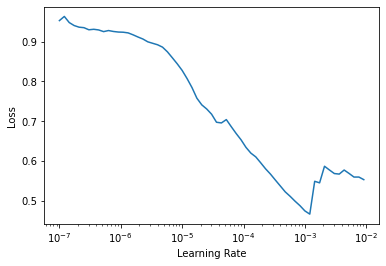

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.077617,0.064304,0.400094,0.864774,07:18
1,0.073341,0.064050,0.395965,0.893417,07:17
2,0.068002,0.061350,0.531013,0.871681,07:14
3,0.055269,0.068252,0.472958,0.880891,07:13
4,0.054680,0.051352,0.545535,0.898572,07:13
5,0.050968,0.049561,0.571110,0.914313,07:12
6,0.048079,0.046953,0.564529,0.914444,07:12
7,0.044176,0.045532,0.641343,0.910027,07:12
8,0.042984,0.044673,0.666555,0.917361,07:12
9,0.039853,0.044556,0.673061,0.915163,07:12


In [ ]:
#segmentation_learner.save("ResNet18-Unet-128-stage1")

Path('models/ResNet18-Unet-stage1.pth')

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.047727,0.050091,0.566619,0.915236,07:10
1,0.049110,0.051488,0.614058,0.889133,07:12
2,0.043920,0.045470,0.589829,0.918991,07:12
3,0.042332,0.043937,0.680346,0.920434,07:12
4,0.039790,0.042920,0.683014,0.923082,07:12


In [ ]:
#segmentation_learner.save("ResNet18-Unet-128-stage2")

Path('models/ResNet18-Unet-stage2.pth')

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.042923491448163986,0.6830139631164355,0.9230815172195435]

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=6.309573450380412e-07)

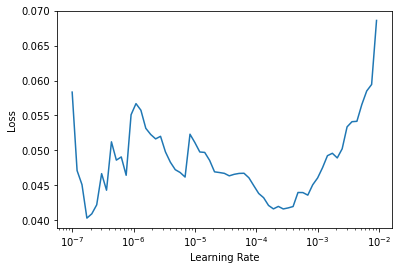

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage3
segmentation_learner.fit_one_cycle(10, lr_max=slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.042608,0.043629,0.685057,0.922095,10:06
1,0.043650,0.044138,0.688359,0.920928,10:05
2,0.042094,0.044083,0.694718,0.919718,10:05
3,0.038842,0.044115,0.684455,0.919441,10:05
4,0.040834,0.042209,0.695586,0.925560,10:06
5,0.038396,0.042617,0.703305,0.929716,10:06
6,0.035363,0.041282,0.713529,0.929295,10:05
7,0.032947,0.041631,0.719175,0.929696,10:05
8,0.034092,0.041418,0.724688,0.930014,10:05
9,0.034992,0.041048,0.727225,0.929578,10:05


In [ ]:
segmentation_learner.save("ResNet18-Unet-128-stage3")

Path('models/ResNet18-Unet-128-stage3.pth')

## Original-size: 256x1600

In [ ]:
bs = 2 # 8 gb
# bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
dls = get_segmentation_dls(bs, (256, 1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage3")

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=7.585775847473997e-07)

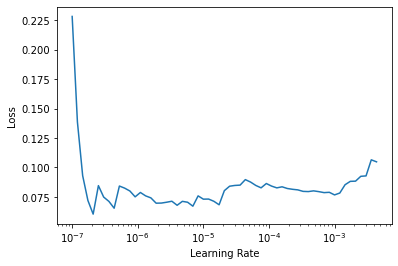

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage1
segmentation_learner.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.048108,0.048416,0.660539,0.897118,40:33
1,0.049675,0.046585,0.670772,0.908768,40:24
2,0.053268,0.048370,0.614278,0.904974,40:22
3,0.047116,0.046116,0.720387,0.905115,40:22
4,0.045527,0.048141,0.707756,0.905977,40:22
5,0.034245,0.051016,0.720741,0.910700,40:23
6,0.040398,0.046979,0.719904,0.917155,40:23
7,0.042392,0.046165,0.714892,0.914811,40:23


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage1")

Path('models/ResNet18-Unet-256-stage1.pth')

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage1")

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=2.75422871709452e-06)

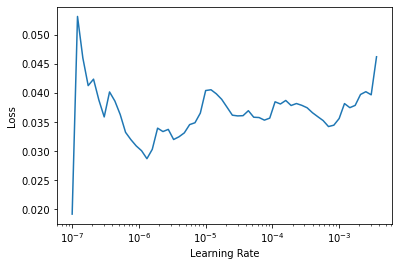

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage2
segmentation_learner.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.034535,0.045978,0.705646,0.922038,29:35
1,0.037973,0.048681,0.663536,0.926412,29:35
2,0.042783,0.043509,0.733397,0.916882,29:35
3,0.043034,0.043290,0.731311,0.918266,29:36


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage2")

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.0431373193860054,0.729721425655278,0.9257643222808838]

In [ ]:
segmentation_learner.unfreeze()

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600), with_btfms=False)
segmentation_learner.dls = orig_dls

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=6.309573450380412e-07)

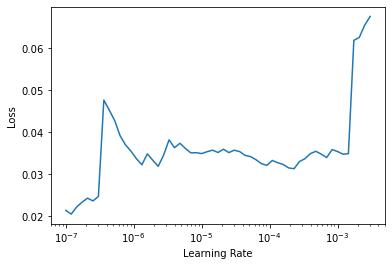

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.041420,0.044097,0.732492,0.902380,30:39
1,0.035430,0.043714,0.728829,0.921726,30:37
2,0.036363,0.041688,0.719019,0.923786,30:36
3,0.039209,0.041530,0.730980,0.927874,30:36
4,0.030240,0.042403,0.735394,0.926116,30:36


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage3")

Path('models/ResNet18-Unet-256-stage3.pth')

## Results

In [ ]:
bs = 2 # 8 gb
# bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
bs = 6 # 8 gb
# bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600), with_btfms=False)
segmentation_learner.dls = orig_dls

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage3")

In [ ]:
segmentation_learner.validate()

(#3) [0.387442409992218,0.21576465218699598,0.7342864274978638]

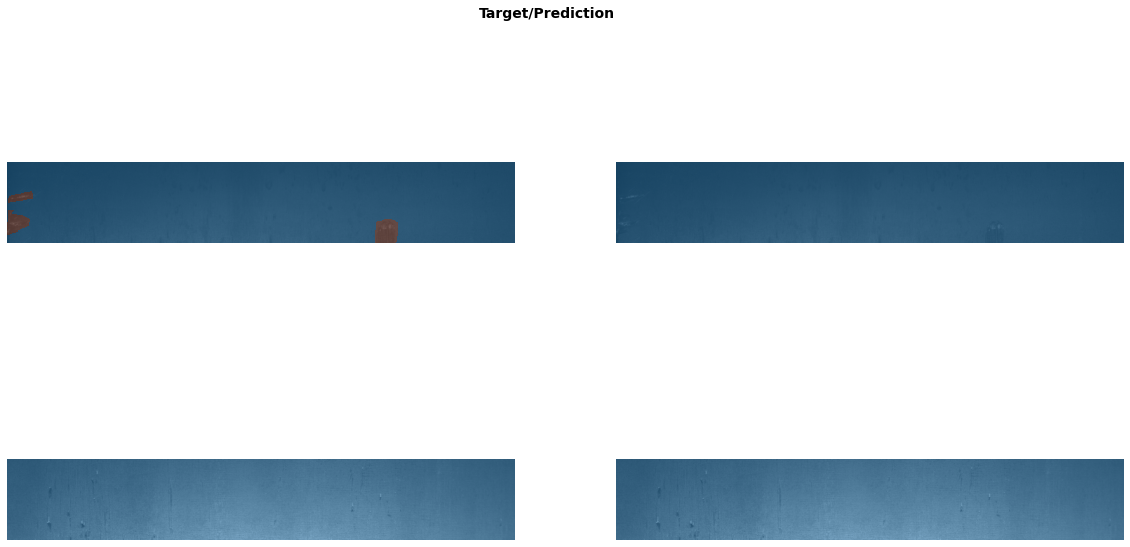

In [ ]:
segmentation_learner.show_results(figsize=(20,10))

## Predictions

*In italiano perché da sviluppare ancora*:

Per salvare gli output del modello è necessario:

1. fare inferenza sul validation set tramite il metodo `get_preds` (se si passa il parametro `with_decoded` permette di ottenere le probabilità invece dei digits).

2. Togliere i gradienti (se non è già stato fatto utilizzando `detach`) e convertire in un `np.array`.

3. Iterare su tutte le immagini, iterare per ogni immagine su ogni classe di difetto e utilizzare funzione `post_process` che filtra tutte le previsioni con pochi pixel data una certa soglia. 

4. Dalle maschere in `np.array` ottenute per ogni immagine, creare una codifica RLE utilizzando la funzione `mask2rle`.

5. Costruire il `pd.DataFrame` con le maschere codificate.

6. Costruire le maschere in formato `png` utilizzando la funzione `create_masks`.

In [ ]:
preds, targs = learn.get_preds() # dovrebbe di default lavorare sul validation set

In [ ]:
# si potrebbe fare sul test set attraverso il metodo DataLoaders.test_dl